# Completed for MSc/MSci level HPC Course

The goal of this notebook is to write a simple particle simulator. Assume we have $N$ particles with strength $k_j > 0$ at the positions $x_j\in\mathbb{R}^2$, $j=0,\dots, N-1$. Each particle creates a potential at a given point $x$ of strength $V_j(x) = -k_j\log |x-x_j|$. The total potential at a given position $x$ is therefore
$$
V(x) = -\sum_{j=0}^{N-1}k_j\log|x-x_j|.
$$

The following code generates $N$ particle positions and a vector of associated strengths.

In [1]:
import numpy as np
from numba import jit, prange

N = 100

rand = np.random.RandomState(0)
pos = rand.rand(N, 2)
k = rand.rand(N)

In [2]:
import pyopencl as cl
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

Let us plot the corresponding particle positions.

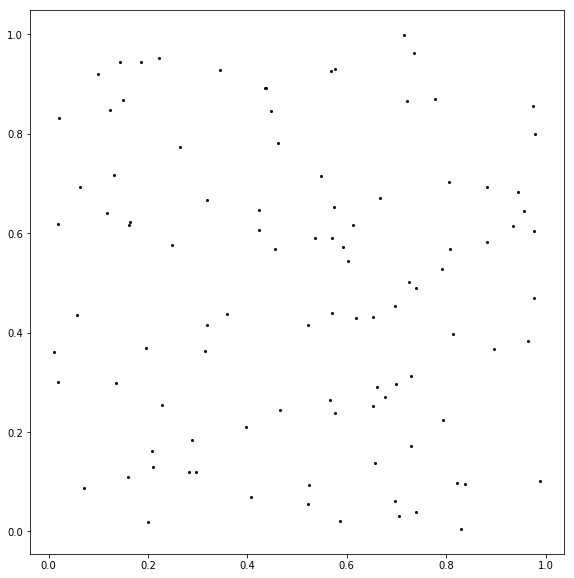

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(pos[:, 0], pos[:, 1], 'k.', markersize=4)
ax.set_aspect('equal')

In [4]:
import numpy as np
from numba import jit, prange
import math 

N = 100

rand = np.random.RandomState(0)
pos = rand.rand(N, 2)
k = rand.rand(N)

import pyopencl as cl
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

def evaluate_field(evaluation_points, source_positions, strength_vector,
                   implementation='numba'):
    """
    Evaluate a field at a given set of points.

    Parameters
    ------------
    evaluation_points : np.ndarray
        A (M, 2) float64 array of M positions that contain the
        two dimensional points at which to evaluate the field.
    source_positions : np.ndarray
        A (N, 2) float64 array of N source positions that contain
        the source locations
    strength_vector : np.ndarray
        A (N, ) float64 array of the strengths associated with
        each source.
    implementation : string
        Either 'numba' or 'opencl' to use a Numba or OpenCL
        implementation.

    Returns
    -------------
    A (M, ) float64 vector of the field values at the corresponding
    evaluation points.

    """
    # initialise an array for the evaluation result
    field_at_points = np.zeros((len(evaluation_points), ), dtype=np.float64)

    if implementation == 'opencl':
        # split 2D vectors into two arrays before passing to OpenCL
        evaluationPointsOpenCL_0 =\
            np.ascontiguousarray(evaluation_points[:, 0])
        evaluationPointsOpenCL_1 =\
            np.ascontiguousarray(evaluation_points[:, 1])
        sourcePositionsOpenCL_0 =\
            np.ascontiguousarray(source_positions[:, 0])
        sourcePositionsOpenCL_1 =\
            np.ascontiguousarray(source_positions[:, 1])

        return evaluate_field_opencl(evaluationPointsOpenCL_0,
                                     evaluationPointsOpenCL_1,
                                     sourcePositionsOpenCL_0,
                                     sourcePositionsOpenCL_1,
                                     strength_vector)
    if implementation == 'numba':

        return evaluate_field_numba(evaluation_points, source_positions,
                                    strength_vector, field_at_points)


@jit(['float64[:](float64[:,:], float64[:,:], float64[:], float64[:])'],
     nopython=True, parallel=True)
def evaluate_field_numba(evaluation_points, source_positions,
                         strength_vector, field_at_points):
    """
    Numba implementation to evaluate field at given coordinates

    Parameters
    ------------
    evaluation_points : np.ndarray
        A (M, 2) float64 array of M positions that contain the
        two dimensional points at which to evaluate the field.
    source_positions : np.ndarray
        A (N, 2) float64 array of N source positions that contain
        the source locations
    strength_vector : np.ndarray
        A (N, ) float64 array of the strengths associated with
        each source.
    field_at_points : np.ndarray
        An (M, ) float64 array that must be passed to the function
        as arrays cannot be created by numba in parallel mode

    Returns
    -------------
    A (M, ) float64 vector of the field values at the corresponding
    evaluation points.

    """
    # initialise range of loops
    M = evaluation_points.shape[0]
    N = source_positions.shape[0]

    # prange makes outer loop parallelised
    for i in prange(M):
        potential = 0.0
        for j in range(N):
            # calculating potenital
            difference_0 = evaluation_points[i][0] - source_positions[j][0]
            difference_1 = evaluation_points[i][1] - source_positions[j][1]
            difference_magnitude = np.sqrt((difference_1)**2 +
                                           (difference_0)**2)
            log_difference_magnitude = (np.log(difference_magnitude))
            # we want negative of the sum, so we minus the accumlator
            potential = potential -\
                (log_difference_magnitude)*strength_vector[j]

        # assign result to result array
        field_at_points[i] = potential

    return field_at_points 
        


def evaluate_field_opencl(evaluation_points_0,
                          evaluation_points_1,
                          source_positions_0,
                          source_positions_1,
                          strength_vector):
    """OpenCL implementation to evaluate field at given coordinates
    
    Parameters
    ------------
    evaluation_points_0 : np.ndarray
        A (M, ) float64 array of M positions in the x dimension
        for evaluation.
    evaluation_points_1 : np.ndarray
        A (M, ) float64 array of M positions in the y dimension
        for evaluation.
    source_positions_0 : np.ndarray
        A (N, ) float64 array of N source positions in the x 
        dimension
    source_positions_1 : np.ndarray
        A (N, ) float64 array of N source positions in the y 
        dimension
    strength_vector : np.ndarray
        A (N, ) float64 array of the strengths associated with
        each source.
        
    Returns
    -------------
    A (M, ) float64 vector of the field values at the corresponding
    evaluation points."""

    kernel = """

    __kernel void evaluate_potential(const int numOfEvaluationPoints,
                                     const int numOfSourcePoints,
                                     __global double *evaluationPoints0,
                                     __global double *evaluationPoints1,
                                     __global double *sourcePoints0,
                                     __global double *sourcePoints1,
                                     __global double *strengthVector,
                                     __global double *result)
    {
    // get thread identifiers 
    int row = get_group_id(0);
    int tid = get_local_id(0);
    int localSize = get_local_size(0);
    
    // calculate number of tiles
    int numTiles = numOfSourcePoints / localSize;
    
    // initialise caches to reduce global memory access 
    __local double localSourcePoints0[TS];
    __local double localSourcePoints1[TS];
    __local double localStrength[TS];

    // initialise points that will be used for each tile 
    double evaluationPoint0 = evaluationPoints0[row*localSize+tid];
    double evaluationPoint1 = evaluationPoints1[row*localSize+tid];
    
    double potential = 0.0;
    
    // make sure doesnt go out of current tile or out of row
    if (tid < localSize) {
        if ((row*localSize+tid) < numOfEvaluationPoints) { 
            for (int i=0; i < numTiles; i++) {
                // load data into caches based on calculated indices
                int i_index = i * localSize + tid;
                localSourcePoints0[tid] = sourcePoints0[i_index];
                localSourcePoints1[tid] = sourcePoints1[i_index];
                localStrength[tid] = strengthVector[i_index];

                // wait for all work groups to synchronise 
                barrier(CLK_LOCAL_MEM_FENCE);
    
                // do calculations for given tile
                for (int j=0; j<localSize; j++) {
                    potential -= log(sqrt(
                        (
                        (((evaluationPoint0 - localSourcePoints0[j]) *
                        (evaluationPoint0 - localSourcePoints0[j]))) +
                        (((evaluationPoint1 - localSourcePoints1[j]) *
                        (evaluationPoint1 - localSourcePoints1[j])))
                        )
                        )) * localStrength[j];
                }

            barrier(CLK_LOCAL_MEM_FENCE);
            }
        }
    }
    
    // write to global memory 
    result[row*localSize+tid] = potential;

    }

    """
    
    n_eval_points = len(evaluation_points_0)
    n_source_positions = len(source_positions_0)

    # trying to estimate optimum work group dimensions
    if n_eval_points < n_source_positions:

        work_group_ratio =\
            (n_source_positions/n_eval_points).as_integer_ratio()
        x_work_group = work_group_ratio[1]
        y_work_group = work_group_ratio[0]

    else:

        work_group_ratio =\
            (n_eval_points/n_source_positions).as_integer_ratio()
        x_work_group = work_group_ratio[1]
        y_work_group = np.int32(work_group_ratio[0]/2)

    # create memory buffers for OpenCL kernels
    mf = cl.mem_flags
    eval_buffer_0 = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                              hostbuf=evaluation_points_0)
    eval_buffer_1 = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                              hostbuf=evaluation_points_1)
    source_buffer_0 = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                                hostbuf=source_positions_0)
    source_buffer_1 = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                                hostbuf=source_positions_1)
    strength_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                                hostbuf=strength_vector)
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR,
                              size=evaluation_points.shape[0] * 8)
    
    # build program from kernel 
    prg = cl.Program(ctx, kernel).build(options=[
                                        '-D', 'TS={0}'.format(x_work_group)])
    potential_kernel = prg.evaluate_potential

    # copy buffers to kernel 
    potential_kernel(queue, (n_eval_points, n_source_positions),
                     (x_work_group, y_work_group),
                     np.int32(n_eval_points), np.int32(n_source_positions),
                     eval_buffer_0, eval_buffer_1, source_buffer_0,
                     source_buffer_1, strength_buffer, result_buffer)

    # get result from kernel 
    result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                      0, (n_eval_points, ), np.double)
    queue.finish()

    return result

In [5]:
Nx = 100
Ny = 100
xpoints, ypoints = np.mgrid[0 : 1: 1j * Nx, 0 : 1: 1j * Ny]
evaluation_points = np.vstack([xpoints.ravel(), ypoints.ravel()]).T

Finally, we want to plot the results. We plot the logs since the result will be large close to the poles.

In [6]:
result_numba = np.log10(np.abs(result_numba.reshape(Nx, Ny)))
result_opencl = np.log10(np.abs(result_opencl.reshape(Nx, Ny)))

NameError: name 'result_numba' is not defined

In [ ]:
figure = plt.figure(figsize=(20, 20))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

ax1.imshow(result_numba.T, extent=[0, 1, 0, 1], origin='lower')
ax1.set_aspect('equal')
ax1.set_title('Numba')

ax2.imshow(result_opencl.T, extent=[0, 1, 0, 1], origin='lower')
ax2.set_aspect('equal')
ax2.set_title('OpenCL')
